In [ ]:
from google.colab import drive
drive.mount('/content/drive')
csv_folder = "/content/drive/MyDrive/csv_files"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install SimpleITK

In [ ]:
# importing dependencies
import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.feature_selection import RFECV

# **Data Preprocessing**

In [ ]:
def data_preprocessing(df):
  pre_scaled = df.iloc[:, :-1].applymap(pd.to_numeric)
  columns_titles = pre_scaled.columns
  scaler = StandardScaler().fit_transform(pre_scaled)
  scaled_data = pd.DataFrame(scaler)
  scaled_data.columns = columns_titles

  label_encoder = LabelEncoder()
  scaled_data['labels']= label_encoder.fit_transform(df.iloc[:,-1])

  return scaled_data

In [ ]:
def pearson_correlation_heatmap(df):
  dataplot = sns.heatmap(df.iloc[:,:-1].corr(numeric_only=True), cmap="YlGnBu", annot=False)
  plt.show()

In [ ]:
def removing_highly_corr_features(df, show_highly_corr=False, show_curr_corr=False):
  corr_matrix = df.corr().abs()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

  to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
  processed_df = df.drop(to_drop, axis=1)
  if show_highly_corr == True:
    print("\nThe correlation matrix of the highly correlated features")
    pearson_correlation_heatmap(pd.concat([df[to_drop], df.iloc[:,-1]], axis=1))

  if show_curr_corr == True:
    print("\nThe correlation matrix of the current features")
    pearson_correlation_heatmap(processed_df)

  print(f"# of dropped feaures: {len(to_drop)}")
  print(f"Dropped features are: {to_drop}")
  print(f"# of remained features {processed_df.shape[1]}")
  print(f"Remained features are: {processed_df.columns}")
  return processed_df

# **ML Models Traning & Evaluation**

In [ ]:
# training & evaluating different models [EDITED]

def estimators_training_evaluation(df):
  X = df.iloc[:, :-1]
  y = df.iloc[:, -1]

  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  lr = LogisticRegression(random_state=42, C= 0.1, penalty='l2', solver='liblinear')
  dt = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=6, min_samples_leaf=1, min_samples_split=2)
  rf = RandomForestClassifier(random_state=42, max_depth=6, min_samples_leaf=1, min_samples_split=5)
  knn = KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
  svm = SVC(random_state=42, C=6, kernel='rbf')

  estimators = [lr, dt, rf, knn, svm]
  scoring_metric = ['accuracy', 'precision_macro', 'f1_macro']

  accuracy_scores_val = []
  precision_macro_scores_val = []
  f1_macro_scores_val = []
  accuracy_scores_test = []
  precision_macro_scores_test = []
  f1_macro_scores_test = []

  print("## Validation Metrics ##")
  for est in estimators:
    print(f"\n{str(est).split('(')[0]}")
    for metric in scoring_metric:
      scores = cross_val_score(est, x_train, y_train, scoring=metric, cv=10)
      metric_score = np.mean(scores)
      print(f"\t\t>> {metric}: {metric_score*100 :.4f}%")

      if metric == "accuracy":
        accuracy_scores_val.append(metric_score*100)
      elif metric == "precision_macro":
        precision_macro_scores_val.append(metric_score*100)
      elif metric == "f1_macro":
        f1_macro_scores_val.append(metric_score*100)

  print("\n\n## Testing Metrics ##")
  for est in estimators:
    est.fit(x_train, y_train)
    print(f"\n{str(est).split('(')[0]}")
    y_pred = est.predict(x_test)

    accuracy_metric = accuracy_score(y_test, y_pred)
    accuracy_scores_test.append(accuracy_metric*100)
    print(f"\t\t>> accuracy metric: {accuracy_metric*100 :.4f}%")

    precisio_metric = precision_score(y_test, y_pred, average = "macro")
    precision_macro_scores_test.append(precisio_metric*100)
    print(f"\t\t>> precisio metric: {precisio_metric*100 :.4f}%")

    f1_metric = f1_score(y_test, y_pred, average = "macro")
    f1_macro_scores_test.append(f1_metric*100)
    print(f"\t\t>> f1 metric: {f1_metric*100 :.4f}%")

  return accuracy_scores_val, precision_macro_scores_val, f1_macro_scores_val, accuracy_scores_test, precision_macro_scores_test, f1_macro_scores_test

In [ ]:
# plotting & saving metric scores figure as png file [DONE]
def estimators_performance_plot(accuracy_scores, precision_macro_scores, f1_macro_scores, save_fig=False):
  estimator = ['lr', 'dt', 'rf', 'knn', 'svm']
  scores = {
      'accuracy scores': accuracy_scores,
      'Precision Scores': precision_macro_scores,
      'F1 Scores': f1_macro_scores}

  x = np.arange(len(estimator))  # the label locations
  width = 0.3  # the width of the bars
  multiplier = 0

  fig, ax = plt.subplots(layout='constrained')

  for attribute, measurement in scores.items():
      offset = width * multiplier
      rects = ax.bar(x + offset, measurement, width, label=attribute)
      ax.bar_label(rects, padding=3, fmt='%.1f')
      multiplier += 1

  ax.set_ylabel("Score")
  ax.set_xlabel("Estimator")
  ax.set_title("Estimator Vs. Metrics Scores")
  ax.set_xticks(x + width, estimator)
  ax.legend(loc='upper center', ncols=3)
  ax.set_ylim(0, 119)
  plt.show()
  if save_fig == True:
    plt.savefig("estimators_performance.png")

# **Deep Features Training & Evaluation**




## **VGG19**

In [ ]:
features_df = pd.read_csv("/content/drive/MyDrive/csv_files/features_vgg19.csv")
processed_df = data_preprocessing(features_df)

<ipython-input-6-f19542a7b552>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pre_scaled = df.iloc[:, :-1].applymap(pd.to_numeric)


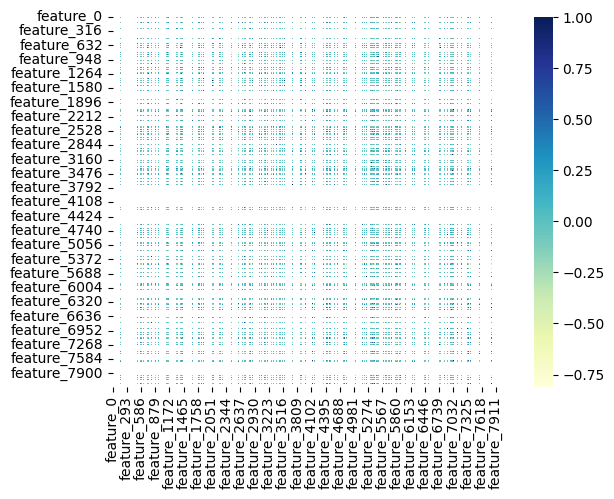


The correlation matrix of the highly correlated features


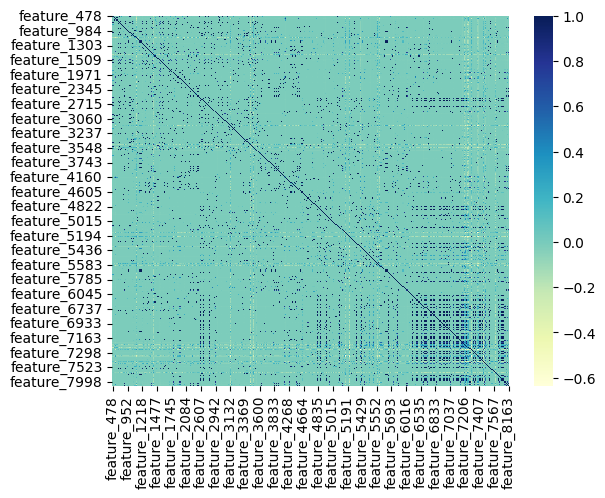


The correlation matrix of the current features


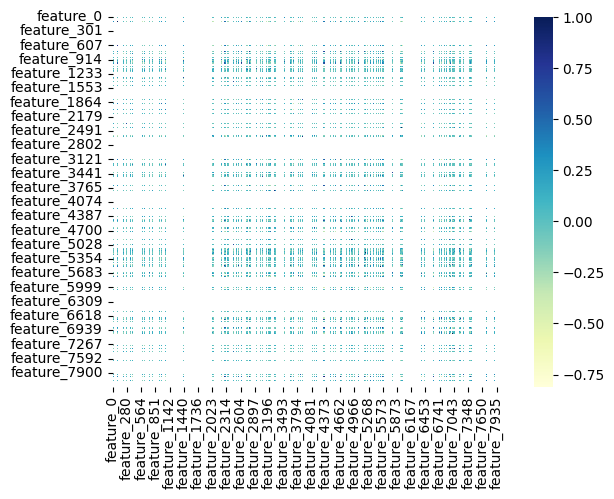

# of dropped feaures: 379
Dropped features are: ['feature_478', 'feature_488', 'feature_489', 'feature_527', 'feature_575', 'feature_629', 'feature_630', 'feature_719', 'feature_733', 'feature_736', 'feature_828', 'feature_916', 'feature_917', 'feature_941', 'feature_952', 'feature_984', 'feature_990', 'feature_1012', 'feature_1027', 'feature_1032', 'feature_1057', 'feature_1086', 'feature_1172', 'feature_1178', 'feature_1180', 'feature_1183', 'feature_1188', 'feature_1199', 'feature_1218', 'feature_1287', 'feature_1303', 'feature_1313', 'feature_1315', 'feature_1350', 'feature_1383', 'feature_1401', 'feature_1405', 'feature_1423', 'feature_1429', 'feature_1430', 'feature_1441', 'feature_1446', 'feature_1477', 'feature_1488', 'feature_1502', 'feature_1509', 'feature_1515', 'feature_1524', 'feature_1561', 'feature_1622', 'feature_1643', 'feature_1657', 'feature_1661', 'feature_1701', 'feature_1708', 'feature_1716', 'feature_1745', 'feature_1789', 'feature_1933', 'feature_1964', 'feature

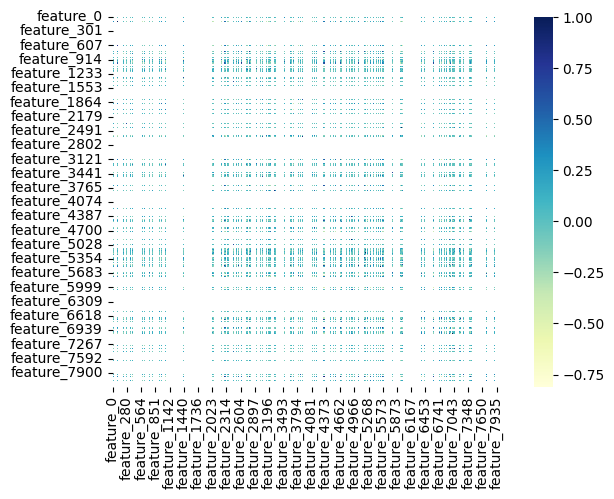

In [ ]:
pearson_correlation_heatmap(processed_df)
processed_df2 = removing_highly_corr_features(processed_df, show_highly_corr=True, show_curr_corr=True)
pearson_correlation_heatmap(processed_df2)

In [ ]:
accuracy_scores_val, precision_macro_scores_val, f1_macro_scores_val, accuracy_scores_test, precision_macro_scores_test, f1_macro_scores_test = estimators_training_evaluation(processed_df2)

## Validation Metrics ##

LogisticRegression
		>> accuracy: 53.7500%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


		>> precision_macro: 53.0417%
		>> f1_macro: 51.3452%

DecisionTreeClassifier
		>> accuracy: 43.7500%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

		>> precision_macro: 43.5417%
		>> f1_macro: 40.5000%

RandomForestClassifier
		>> accuracy: 58.7500%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

		>> precision_macro: 58.4583%
		>> f1_macro: 56.0635%

KNeighborsClassifier
		>> accuracy: 41.2500%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

		>> precision_macro: 27.1250%
		>> f1_macro: 31.1905%

SVC
		>> accuracy: 55.0000%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

		>> precision_macro: 49.7500%
		>> f1_macro: 50.5833%


## Testing Metrics ##

LogisticRegression
		>> accuracy metric: 75.0000%
		>> precisio metric: 70.0000%
		>> f1 metric: 69.8485%

DecisionTreeClassifier
		>> accuracy metric: 40.0000%
		>> precisio metric: 50.0000%
		>> f1 metric: 39.7475%

RandomForestClassifier
		>> accuracy metric: 50.0000%
		>> precisio metric: 58.3333%
		>> f1 metric: 47.5000%

KNeighborsClassifier
		>> accuracy metric: 35.0000%
		>> precisio metric: 15.6250%
		>> f1 metric: 21.6667%

SVC
		>> accuracy metric: 50.0000%
		>> precisio metric: 67.5000%
		>> f1 metric: 48.4217%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


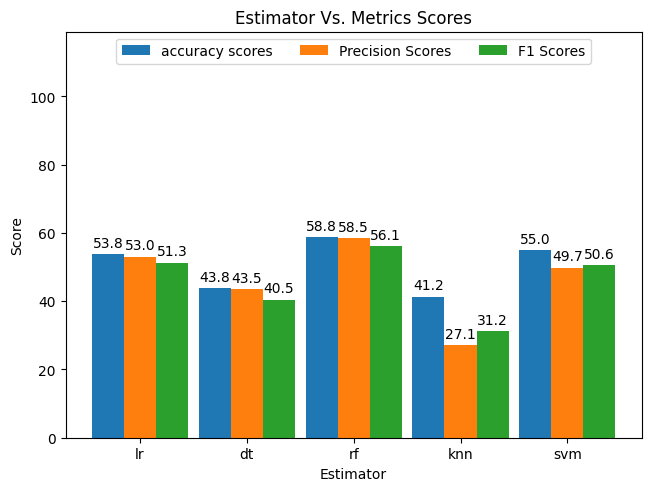

<Figure size 640x480 with 0 Axes>

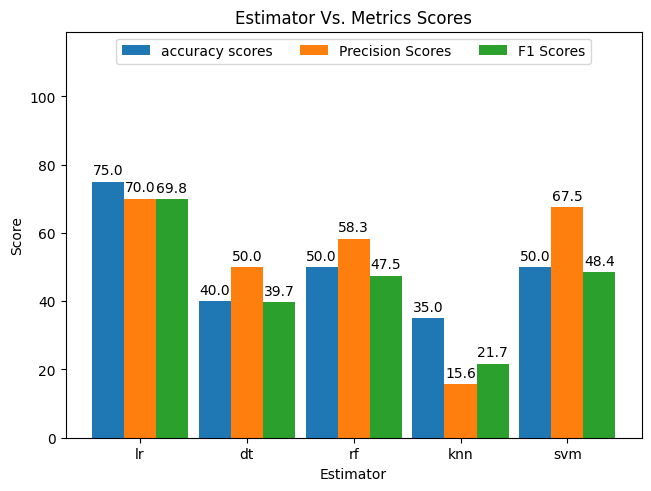

<Figure size 640x480 with 0 Axes>

In [ ]:
estimators_performance_plot(accuracy_scores_val, precision_macro_scores_val, f1_macro_scores_val, save_fig=True)
estimators_performance_plot(accuracy_scores_test, precision_macro_scores_test, f1_macro_scores_test, save_fig=True)

## **InceptionV3**

In [ ]:
features_df = pd.read_csv("/content/drive/MyDrive/csv_files/sample_features_inception V3.csv")
processed_df = data_preprocessing(features_df)

<ipython-input-7-f19542a7b552>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pre_scaled = df.iloc[:, :-1].applymap(pd.to_numeric)



The correlation matrix of the highly correlated features


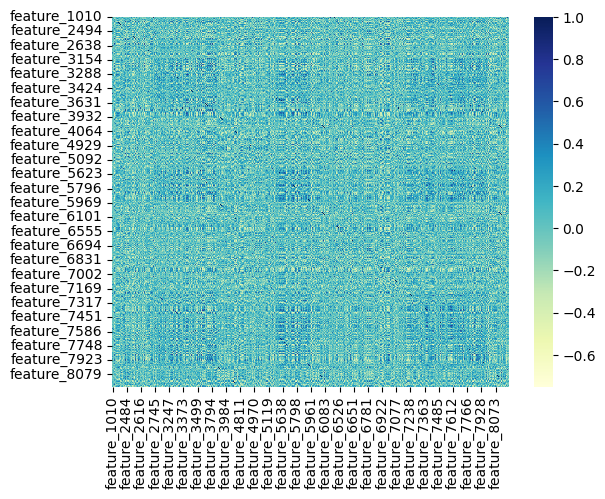


The correlation matrix of the current features


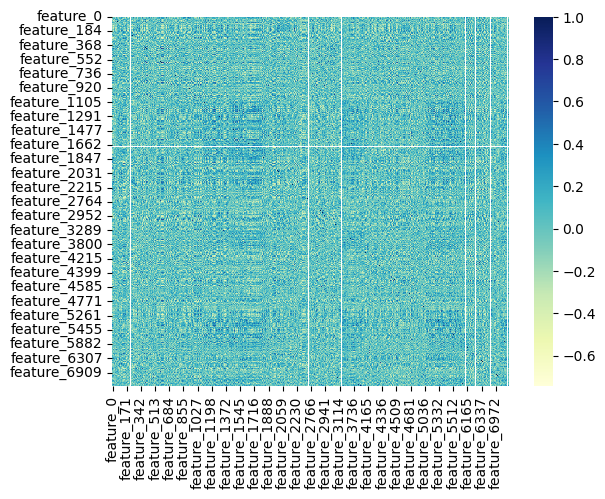

# of dropped feaures: 3412
Dropped features are: ['feature_1010', 'feature_1258', 'feature_1271', 'feature_1351', 'feature_1451', 'feature_1480', 'feature_1764', 'feature_2263', 'feature_2274', 'feature_2368', 'feature_2369', 'feature_2370', 'feature_2371', 'feature_2372', 'feature_2373', 'feature_2374', 'feature_2375', 'feature_2376', 'feature_2377', 'feature_2378', 'feature_2379', 'feature_2380', 'feature_2381', 'feature_2382', 'feature_2384', 'feature_2385', 'feature_2386', 'feature_2387', 'feature_2388', 'feature_2389', 'feature_2390', 'feature_2391', 'feature_2392', 'feature_2393', 'feature_2394', 'feature_2395', 'feature_2396', 'feature_2397', 'feature_2398', 'feature_2399', 'feature_2400', 'feature_2401', 'feature_2402', 'feature_2403', 'feature_2404', 'feature_2405', 'feature_2406', 'feature_2407', 'feature_2409', 'feature_2410', 'feature_2411', 'feature_2412', 'feature_2413', 'feature_2414', 'feature_2415', 'feature_2416', 'feature_2417', 'feature_2418', 'feature_2419', 'featu

In [ ]:
processed_df2 = removing_highly_corr_features(processed_df, show_highly_corr=True, show_curr_corr=True)

In [ ]:
accuracy_scores_val, precision_macro_scores_val, f1_macro_scores_val, accuracy_scores_test, precision_macro_scores_test, f1_macro_scores_test = estimators_training_evaluation(processed_df2)

## Validation Metrics ##

LogisticRegression
		>> accuracy: 65.0000%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


		>> precision_macro: 65.4167%
		>> f1_macro: 62.9167%

DecisionTreeClassifier
		>> accuracy: 50.0000%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


		>> precision_macro: 49.1667%
		>> f1_macro: 46.3929%

RandomForestClassifier
		>> accuracy: 62.5000%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


		>> precision_macro: 60.4167%
		>> f1_macro: 59.1429%

KNeighborsClassifier
		>> accuracy: 57.5000%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

		>> precision_macro: 53.7083%
		>> f1_macro: 52.8214%

SVC
		>> accuracy: 63.7500%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


		>> precision_macro: 61.4583%
		>> f1_macro: 60.5119%


## Testing Metrics ##

LogisticRegression
		>> accuracy metric: 50.0000%
		>> precisio metric: 54.1667%
		>> f1 metric: 52.5000%

DecisionTreeClassifier
		>> accuracy metric: 30.0000%
		>> precisio metric: 32.5000%
		>> f1 metric: 30.7576%

RandomForestClassifier
		>> accuracy metric: 45.0000%
		>> precisio metric: 49.4048%
		>> f1 metric: 46.1364%

KNeighborsClassifier
		>> accuracy metric: 45.0000%
		>> precisio metric: 39.2857%
		>> f1 metric: 40.9091%

SVC
		>> accuracy metric: 35.0000%
		>> precisio metric: 36.6667%
		>> f1 metric: 36.3131%


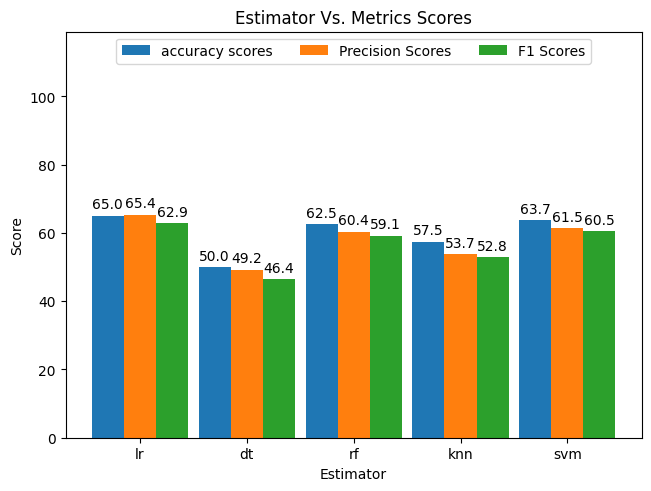

<Figure size 640x480 with 0 Axes>

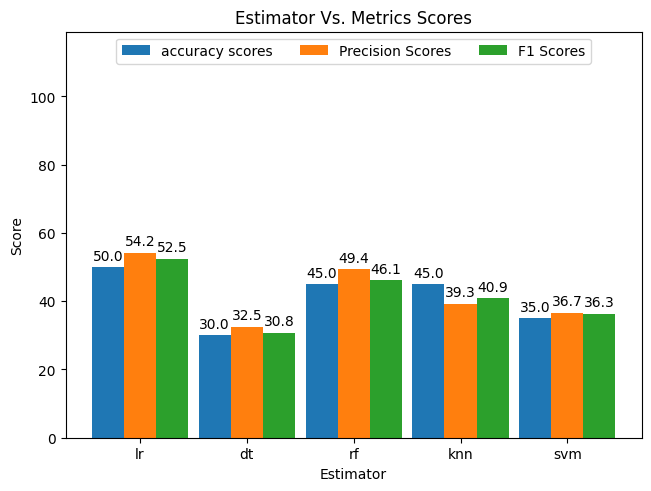

<Figure size 640x480 with 0 Axes>

In [ ]:
estimators_performance_plot(accuracy_scores_val, precision_macro_scores_val, f1_macro_scores_val, save_fig=True)
estimators_performance_plot(accuracy_scores_test, precision_macro_scores_test, f1_macro_scores_test, save_fig=True)